## Tidy3D first walkthrough

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/Simulation.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/Simulation.ipynb), or just follow along with the output below.

Our first tutorial focuses on illustrating the basic setup, run, and analysis of a ``Tidy3D`` simulation. In this example, we will simulate a plane wave impinging on dielectric slab with a triangular pillar made of a lossy dielectric sitting on top. First, we import everything needed.

In [1]:
# get the most recent version of tidy3d
# !pip install -q --upgrade tidy3d

# make sure notebook plots inline
# %matplotlib inline

# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import h5py

# tidy3D import
import sys
sys.path.append('../../tidy3d')
import tidy3d as td
from tidy3d import web

First, we initialize some general simulation parameters. We note that the PML layers extend **beyond** the simulation domain, making the total simulation size larger - as opposed to some solvers in which the PML is covering part of the user-defined simulation domain.

In [2]:
# Resolution in x, y, z (points per micron)
resolution = 20

# Simulation domain size (in micron)
sim_size = [4, 4, 4]

# Central frequency and bandwidth of pulsed excitation, in Hz
fcen = 2e14
fwidth = 1e13

# Number of PML layers to use along each of the three directions.
pml_layers = [12, 12, 12]

The run time of a simulation depends a lot on whether there are any long-lived resonances. In our example here, there is no strong resonance. Thus, we do not need to run the simulation much longer than after the sources have decayed. We thus set the run time based on the source bandwidth.

In [3]:
# Total time to run in seconds
run_time = 2/fwidth

### Structures and materials

Next, we initialize the simulated structure. The structure consists of two geometric objects. Each object is made of a material. Note that the size of any object (structure, source, or monitor) can extend beyond the simulation domain, and is truncated at the edges of that domain. For best results with PML layers, structures must extend all the way through the PMLs. In some such cases, an "infinite" size `td.inf` can be used to define the size.

In [4]:
# Lossless dielectric
material1 = td.Medium(permittivity=6.)
# Lossy dielectric defined from the real and imaginary part of the refractive index
material2 = td.Medium.from_nk(n=1.5, k=0.1, freq=fcen)

# Rectangular slab
box = td.Structure(
    geometry=td.Box(center=[0, 0, 0], size=[td.inf, td.inf, 1]),
    medium=material1
)

# Triangle in the xy-plane with a finite extent in z
equi_tri_verts = [[-1/2, -1/4],
                  [1/2, -1/4],
                  [0, np.sqrt(3)/2 - 1/4]]
poly = td.Structure(
    geometry=td.PolySlab(
        # vertices=2*np.array(equi_tri_verts).tolist(), 
        vertices=equi_tri_verts, 
        slab_bounds=(.5, 1.0),
        axis=2),
    medium=material2)

### Sources

Next, we define a source injecting a normal-incidence plane-wave from above. The time dependence of the source is a Gaussian pulse. A source can be added to multiple simulations. After we add the source to a specific simulation, such that the total run time is known, we can use in-built plotting tools to visualize its time- and frequency-dependence, which we will show below.

In [5]:
psource = td.PlaneWave(
    center=(0,0,1.5),
    direction='-',
    size=(td.inf, td.inf, 0),
    source_time = td.GaussianPulse(
        freq0=fcen,
        fwidth=fwidth),
    polarization='Ey')


### Monitors

Finally, we can also add some monitors that will record the fields that we request during the simulation run. The two main types are time monitors that record the time-domain fields, and frequency monitors that record a running discrete Fourier transform of the fields at a given set of frequencies. Time monitors are best used to monitor the time dependence of the fields at a single point. Spatially large time monitors can lead to a very large amount of data that needs to be stored. Frequency monitors on the other hand are great for investigating the steady-state field distribution in 2D or even 3D regions of the simulation.

In [6]:
time_mnt = td.FieldTimeMonitor(center=[0, 0, 0], size=[0, 0, 0], name='field_time')
freq_mnt1 = td.FieldMonitor(center=[0, 0, -1], size=[20, 20, 0], freqs=[fcen], name='field1')
freq_mnt2 = td.FieldMonitor(center=[0, 0, 0], size=[20, 0, 20], freqs=[fcen], name='field2')

### Simulation

Now we can initialize the simulation with all the elements defined above.

In [7]:
# Initialize simulation
sim = td.Simulation(size=sim_size,
                    grid_size=3*[1/resolution], 
                    structures=[box, poly], 
                    sources=[psource],
                    monitors=[time_mnt, freq_mnt1, freq_mnt2],
                    run_time=run_time,
                    pml_layers=3*[td.PML()])

We can check the simulation monitors just to make sure everything looks right.

In [8]:
from pprint import pprint as print
print(sim.dict())

{'center': (0.0, 0.0, 0.0),
 'courant': 0.9,
 'grid_size': (0.05, 0.05, 0.05),
 'medium': {'conductivity': 0.0,
            'frequency_range': None,
            'name': 'mediums[1]',
            'permittivity': 1.0,
            'type': 'Medium'},
 'monitors': [{'center': (0.0, 0.0, 0.0),
               'data_type': 'ScalarFieldTimeData',
               'fields': ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
               'interval': 1,
               'name': 'field_time',
               'size': (0.0, 0.0, 0.0),
               'start': 0.0,
               'stop': None,
               'type': 'FieldTimeMonitor'},
              {'center': (0.0, 0.0, -1.0),
               'data_type': 'ScalarFieldData',
               'fields': ['Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'],
               'freqs': [200000000000000.0],
               'name': 'field1',
               'size': (20.0, 20.0, 0.0),
               'type': 'FieldMonitor'},
              {'center': (0.0, 0.0, 0.0),
               'data_type': 'Scal

### Visualization functions

We can now use the some in-built plotting functions to make sure that we have set up the simulation as we desire.

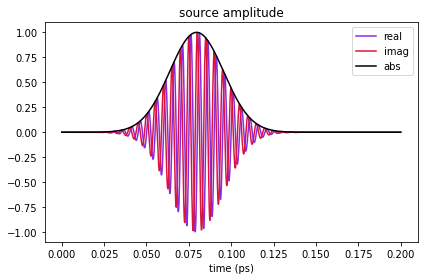

In [9]:
# Visualize source
psource.source_time.plot(np.linspace(0, run_time, 1001))
plt.show()

To visualize the structures in the simulation, we will plot three cross sections at `z=0.75`, `y=0`, and `x=0`, respectively. The relative permittivity of objects is plotted in greyscale. By default, sources are overlayed in green, monitors in yellow, and PML boundaries in orange. As an example, in the middle plot (`y=0`), we turn off the monitor overlay since the monitor covers the whole cross-section, while in the right-most plot, we make the source more visible.

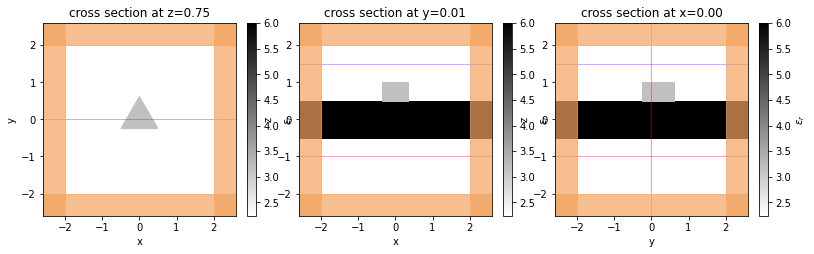

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))
sim.plot_eps(z=0.75, ax=ax[0]);
sim.plot_eps(y=0.01, ax=ax[1]);
sim.plot_eps(x=0, ax=ax[2]);

Alternatively, we can also plot the structures with a fake color based on the material they are made of.

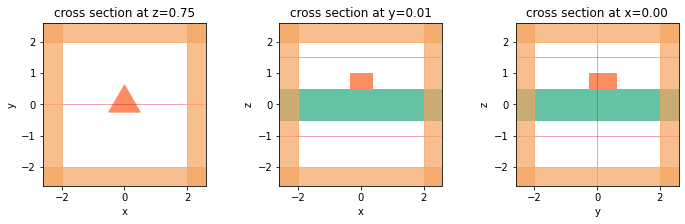

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))
sim.plot(z=0.75, ax=ax[0]);
sim.plot(y=0.01, ax=ax[1]);
sim.plot(x=0, ax=ax[2]);

### Running through the web API

Now that the simulation is constructed, we can run it using the `web` API of ``Tidy3D``. First, we submit the project. Note that we can give it a custom name.

In [12]:
task_id = web.upload(sim, task_name='Simulation')
web.start(task_id)

[17:04:01] INFO     Uploaded task 'Simulation' with task_id                      ]8;id=190375;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:84
                    '37e060a6-6e99-4dd3-8ee1-af6ef0c8235e'.

We can continously monitor the status of the current project, and wait until the run is successful. The `monitor_project()` function will keep running until either a `'success'` or `'error'` status is returned.

In [13]:
web.monitor(task_id)

Output()

[17:04:03] status = queued                                                      ]8;id=381824;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:176

[17:04:39] status = queued_solver                                               ]8;id=637656;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:176

[17:04:40] status = running                                                     ]8;id=219621;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:176

[17:04:51] status = postprocess                                                 ]8;id=590904;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:176

[17:05:02] status = visualize                                                   ]8;id=680624;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:176

[17:05:06] status = success                                                     ]8;id=684164;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:176

## Loading and analyzing data

After a successful run, we can download the results and load them into our simulation model. We use the `download_results` function from our web API, which downloads a single `hdf5` file containing all the monitor data, a log file, and a `json` file defining the original simulation (same as what you'll get if you run `sim.to_json()` on the current object). Optionally, you can provide a folder in which to store the files. In the example below, the results are stored in the `out` folder. 

In [14]:
sim_data = web.load(task_id, simulation=sim, path='data/sim_data.hdf5')

# Show the output of the log file
print(sim_data.log)

[17:05:07] INFO     downloading file "simulation.json" to                       ]8;id=283423;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:393
                    "data/simulation.json"

Output()

           INFO     downloading file "monitor_data.hdf5" to                     ]8;id=447413;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:393
                    "data/monitor_data.hdf5"

Output()

[17:05:08] INFO     downloading file "tidy3d.log" to "data/tidy3d.log"          ]8;id=820121;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:393

Output()

[17:05:09] INFO     exporting SimulationData to data/sim_data.hdf5              ]8;id=967334;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:266

           INFO     loading SimulationData from data/sim_data.hdf5              ]8;id=787492;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:302

('Simulation domain Nx, Ny, Nz: [104, 104, 104]\n'
 'Applied symmetries: [0, 0, 0]\n'
 'Number of computational grid points: 1.1249e+06.\n'
 'Using subpixel averaging: True\n'
 'Number of time steps: 2308\n'
 'Automatic shutoff factor: 1.00e-05\n'
 'Time step (s): 8.6662e-17\n'
 '\n'
 'Get source modes time (s):    0.1304\n'
 'Get monitor modes time (s):   0.0383\n'
 'Rest of setup time (s):       0.0775\n'
 '\n'
 'Starting solver...\n'
 '- Time step     92 / time 7.97e-15s (  4 % done), field decay: 1.00e+00\n'
 '- Time step    184 / time 1.59e-14s (  8 % done), field decay: 1.00e+00\n'
 '- Time step    276 / time 2.39e-14s ( 12 % done), field decay: 1.00e+00\n'
 '- Time step    369 / time 3.20e-14s ( 16 % done), field decay: 1.00e+00\n'
 '- Time step    461 / time 4.00e-14s ( 20 % done), field decay: 1.00e+00\n'
 '- Time step    553 / time 4.79e-14s ( 24 % done), field decay: 1.00e+00\n'
 '- Time step    646 / time 5.60e-14s ( 28 % done), field decay: 1.00e+00\n'
 '- Time step    738

### Visualization functions

Finally, we can now use the in-built visualization tools to examine the results. Below, we plot the `y`-component of the field recorded by the two frequency monitors (this is the dominant component since the source is `y`-polarized).

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_1751/2685102885.py:2 in        │
│ <module>                                                                                  │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_1751/2685102885.py'           │
│ /Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/comp │
│ onents/viz.py:32 in _plot                                                                 │
│                                                                                           │
│    29 │   │   if kwargs.get("ax") is None:                                                │
│    30 │   │   │   ax = make_ax()                                                          │
│    31 │   │   │   kwargs["ax"] = ax                                                       │
│ ❱  32 │   │   return plot(*args, **kwargs)                                                │
│    33 │                                                                                   │
│    34 │   return _plot                                                                    │
│    35                                                                                     │
│                                                                                           │
│ /Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/comp │
│ onents/data.py:770 in plot_field                                                          │
│                                                                                           │
│   767 │   │   if "f" in xr_data.coords:                                                   │
│   768 │   │   │   if freq is None:                                                        │
│   769 │   │   │   │   raise DataError("'freq' must be supplied to plot a FieldMonitor.")  │
│ ❱ 770 │   │   │   field_data = xr_data.interp(f=freq)                                     │
│   771 │   │   elif "t" in xr_data.coords:                                                 │
│   772 │   │   │   if time is None:                                                        │
│   773 │   │   │   │   raise DataError("'time' must be supplied to plot a FieldMonitor.")  │
│                                                                                           │
│ /usr/local/lib/python3.9/site-packages/xarray/core/dataarray.py:1725 in interp            │
│                                                                                           │
│   1722 │   │   │   │   "interp only works for a numeric type array. "                     │
│   1723 │   │   │   │   "Given {}.".format(self.dtype)                                     │
│   1724 │   │   │   )                                                                      │
│ ❱ 1725 │   │   ds = self._to_temp_dataset().interp(                                       │
│   1726 │   │   │   coords,                                                                │
│   1727 │   │   │   method=method,                                                         │
│   1728 │   │   │   kwargs=kwargs,                                                         │
│                                                                                           │
│ /usr/local/lib/python3.9/site-packages/xarray/core/dataset.py:3158 in interp              │
│                                                                                           │
│   3155 │   │   │   if dtype_kind in "uifc":                                               │
│   3156 │   │   │   │   # For normal number types d

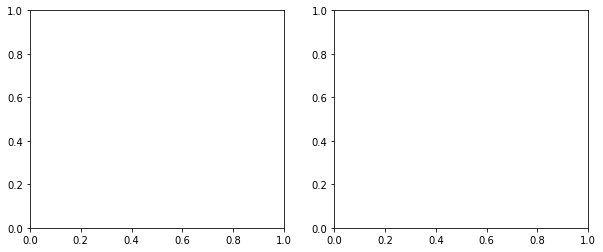

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sim_data.plot_field('field1', 'Ex', z=0.0, ax=ax[0], freq=fcen, val='re');
sim_data.plot_field('field2', 'Ex', z=0.0, ax=ax[1], freq=fcen, val='re');

### Monitor data in Simulation object and in hdf5 file
The raw data is also accessible as numpy arrays and can be queried using `sim.data(monitor)`. 

In [ ]:
mon1_data = sim_data['field1']
mon1_data.Ex

We can use this raw data for example to also plot the time-domain fields recorded in the TimeMonitor, which look largely like a delayed version of the source input, indicating that no resonant features were excited.

In [ ]:
fig, ax = plt.subplots(1)
time_data.Ey.isel(x=0, y=0, z=0).plot(x='t')
ax.set_xlabel("Time [s]")
ax.set_ylabel("Ey [a. u.]")
plt.show()

Finally, the raw data is also accessible through the `hdf5` file. 

In [ ]:
# # Open the data file and print stored groups and datasets
# data_file = h5py.File("data/sim_data.hdf5", "r")
# print("Data groups stored in file:   ", list(data_file.keys()))
# print("Datasets in 'monitor_2': ", list(data_file['monitor_2'].keys()))

# # Read the E-field of the second FreqMonitor
# E_hdf5 = np.array(data_file['monitor_2']['E'])
# x_hdf5 = np.array(data_file['monitor_2']['xmesh'])
# y_hdf5 = np.array(data_file['monitor_2']['ymesh'])
# z_hdf5 = np.array(data_file['monitor_2']['zmesh'])

# # Close the file
# data_file.close()

### Permittivity data

We can also query the relative permittivity in the simulation within a volume of a given `center` and `size`. The method [Simulation.epsilon](../generated/tidy3d.Simulation.epsilon.rst) returns the permittivity at all Yee grid locations inside the specified volume. Instead of manually setting a volume, we can also input a monitor, in which case the fields in that monitor volume are returned.

In [ ]:
# eps, mesh = sim.epsilon(freq_mnt2)

The permittivity data is returned at the same locations that the E field at which the E field is stored in the monitor.

In [ ]:
# print("Shape of permittivity array (x, y, z)              : ", eps.shape)
# print("Shape of E-field (polarization, x, y, z, frequency): ", E_hdf5.shape)

We can use this data to approximately reproduce the figure we get from the built-in visualization. Note that in the in-build function, permittivity of 1 (vacuum) is automatically made fully transparent.

In [ ]:
# fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# # Built-in Tidy3D viz
# sim.viz_field_2D(sim.monitors[2], ax=ax[0], cbar=True, comp='y', val='re', eps_alpha=0.3);

# # Manually from data loaded from the hdf5 file
# ax[1].imshow(np.real(E_hdf5[1, :, 0, :, 0]).T, cmap='RdBu', origin='lower',
#                  extent=[x_hdf5[0], x_hdf5[-1], z_hdf5[0], z_hdf5[-1]])
# # Overlay the permittivity data
# ax[1].imshow(np.real(eps[:, 0, :]).T, alpha=0.3,
#                  extent=[mesh[0][0], mesh[0][-1], mesh[2][0], mesh[2][-1]],
#                  origin='lower', cmap='Greys')
# plt.show()